In [1]:
# Celda 1: Importar librerías necesarias
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
import lightgbm as lgb
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.impute import KNNImputer
from catboost import CatBoostRegressor
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV

# Celda 2: Cargar los datos
train = pd.read_csv('D:\\Ale\\Competitions\\House Prices\\Data\\train.csv')
test = pd.read_csv('D:\\Ale\\Competitions\\House Prices\\Data\\test.csv')

d:\Pyt\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Función para obtener el tipo de dato de una columna
def get_type(dtype):
    # Verifica si el tipo de dato es de cadena (string)
    if pd.api.types.is_string_dtype(dtype):
        return 'string'  # Retorna 'string' si es de tipo cadena
    # Verifica si el tipo de dato es numérico
    elif pd.api.types.is_numeric_dtype(dtype):
        return 'number'  # Retorna 'number' si es de tipo numérico
    else:
        return 'object'  # Retorna 'object' para otros tipos de datos

#Función para calcular el porcentaje de valores nulos por columna junto con el tipo de dato
def null_percentage_with_type(df):
    # Cuenta los valores nulos por columna
    null_count = df.isnull().sum()
    # Obtiene el total de filas en el DataFrame
    total_rows = len(df)
    # Calcula el porcentaje de valores nulos
    percent_null = (null_count / total_rows) * 100
    # Obtiene el tipo de dato de cada columna usando la función get_type
    dtypes = df.dtypes.apply(get_type)
    
    # Crea un DataFrame que contiene la información sobre los nulos y el tipo de dato
    null_info = pd.DataFrame({
        'Column': df.columns,  # Nombre de la columna
        'Null Count': null_count,  # Conteo de valores nulos
        'Percentage Null': percent_null,  # Porcentaje de valores nulos
        'Type': dtypes  # Tipo de dato
    })
    # Devuelve solo las columnas que tienen valores nulos, ordenadas por porcentaje de nulos de forma descendente
    return null_info[null_info['Null Count'] > 0].sort_values(by='Percentage Null', ascending=False)

# Calcular el porcentaje de nulos y tipo de dato para el conjunto de entrenamiento
train_null_info = null_percentage_with_type(train)

#Mostrar las tablas con tabulate
print("Null Percentage and Types in Train Data:")
#Imprime la información de los nulos en el conjunto de entrenamiento en formato de tabla
print(tabulate(train_null_info, headers='keys', tablefmt='grid'))

Null Percentage and Types in Train Data:
+--------------+--------------+--------------+-------------------+--------+
|              | Column       |   Null Count |   Percentage Null | Type   |
+==============+==============+==============+===================+========+
| PoolQC       | PoolQC       |         1453 |        99.5205    | string |
+--------------+--------------+--------------+-------------------+--------+
| MiscFeature  | MiscFeature  |         1406 |        96.3014    | string |
+--------------+--------------+--------------+-------------------+--------+
| Alley        | Alley        |         1369 |        93.7671    | string |
+--------------+--------------+--------------+-------------------+--------+
| Fence        | Fence        |         1179 |        80.7534    | string |
+--------------+--------------+--------------+-------------------+--------+
| MasVnrType   | MasVnrType   |          872 |        59.726     | string |
+--------------+--------------+--------------+-

In [3]:
# Lista de columnas a eliminar manualmente
columns_to_drop1 = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType', 'FireplaceQu']

# Eliminar las columnas en train y test
train_cleaned = train.drop(columns=columns_to_drop1)

# Verificar las columnas eliminadas
print(f"Columnas eliminadas: {columns_to_drop1}")

Columnas eliminadas: ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType', 'FireplaceQu']


In [4]:
#Imputación de valores numéricos usando KNN
knn_columns = ['MasVnrArea', 'GarageYrBlt', 'LotFrontage']
knn_imputer = KNNImputer(n_neighbors=7)
train_cleaned[knn_columns] = knn_imputer.fit_transform(train_cleaned[knn_columns])

In [5]:
# Calcular el porcentaje de nulos y tipo de dato para train
train_null_info = null_percentage_with_type(train_cleaned)

#Mostrar las tablas con tabulate
print("Null Percentage and Types in Train Data:")
print(tabulate(train_null_info, headers='keys', tablefmt='grid'))

Null Percentage and Types in Train Data:
+--------------+--------------+--------------+-------------------+--------+
|              | Column       |   Null Count |   Percentage Null | Type   |
+==============+==============+==============+===================+========+
| GarageType   | GarageType   |           81 |         5.54795   | string |
+--------------+--------------+--------------+-------------------+--------+
| GarageFinish | GarageFinish |           81 |         5.54795   | string |
+--------------+--------------+--------------+-------------------+--------+
| GarageQual   | GarageQual   |           81 |         5.54795   | string |
+--------------+--------------+--------------+-------------------+--------+
| GarageCond   | GarageCond   |           81 |         5.54795   | string |
+--------------+--------------+--------------+-------------------+--------+
| BsmtExposure | BsmtExposure |           38 |         2.60274   | string |
+--------------+--------------+--------------+-

In [6]:
# Identificar las columnas con valores nulos
columns_with_nans = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 
                      'BsmtExposure', 'BsmtFinType2', 'BsmtQual', 
                      'BsmtCond', 'BsmtFinType1', 'Electrical']
# Imputación de valores categóricos usando la moda
for col in columns_with_nans:
    # Calcular la moda para la columna
    mode_value = train_cleaned[col].mode()[0]
    # Imputar los valores nulos con la moda
    train_cleaned[col] = train_cleaned[col].fillna(mode_value)

In [7]:
# Calcular el porcentaje de nulos y tipo de dato para train y test
train_null_info = null_percentage_with_type(train_cleaned)

# Mostrar las tablas con tabulate
print("Null Percentage and Types in Train Data:")
print(tabulate(train_null_info, headers='keys', tablefmt='grid'))

Null Percentage and Types in Train Data:
+----------+--------------+-------------------+--------+
| Column   | Null Count   | Percentage Null   | Type   |
+==========+==============+===================+========+
+----------+--------------+-------------------+--------+


In [8]:
# Función para contar variaciones únicas en columnas de tipo string
def count_unique_variations(df):
    unique_info = []
    for column in df.select_dtypes(include=['object']):  # Filtrar solo columnas de tipo string
        value_counts = df[column].value_counts()  # Contar las variantes y sus frecuencias
        for value, count in value_counts.items():
            unique_info.append({
                'Column': column,
                'Variant': value,
                'Count': count
            })
    
    return pd.DataFrame(unique_info)

# Contar variaciones únicas en el DataFrame
unique_variations_df = count_unique_variations(train_cleaned)

# Mostrar los resultados con tabulate
print("Unique Variations in String Columns:")
print(tabulate(unique_variations_df, headers='keys', tablefmt='grid'))

Unique Variations in String Columns:
+-----+---------------+-----------+---------+
|     | Column        | Variant   |   Count |
+=====+===============+===========+=========+
|   0 | MSZoning      | RL        |    1151 |
+-----+---------------+-----------+---------+
|   1 | MSZoning      | RM        |     218 |
+-----+---------------+-----------+---------+
|   2 | MSZoning      | FV        |      65 |
+-----+---------------+-----------+---------+
|   3 | MSZoning      | RH        |      16 |
+-----+---------------+-----------+---------+
|   4 | MSZoning      | C (all)   |      10 |
+-----+---------------+-----------+---------+
|   5 | Street        | Pave      |    1454 |
+-----+---------------+-----------+---------+
|   6 | Street        | Grvl      |       6 |
+-----+---------------+-----------+---------+
|   7 | LotShape      | Reg       |     925 |
+-----+---------------+-----------+---------+
|   8 | LotShape      | IR1       |     484 |
+-----+---------------+-----------+--------

In [9]:
# Lista de columnas a eliminar manualmente
columns_to_drop = ['Utilities', 'Street', 'LandSlope', 'Condition2','RoofMatl']

# Eliminar las columnas en train y test
train_cleaned = train_cleaned.drop(columns=columns_to_drop)

# Verificar las columnas eliminadas
print(f"Columnas eliminadas: {columns_to_drop}")

Columnas eliminadas: ['Utilities', 'Street', 'LandSlope', 'Condition2', 'RoofMatl']


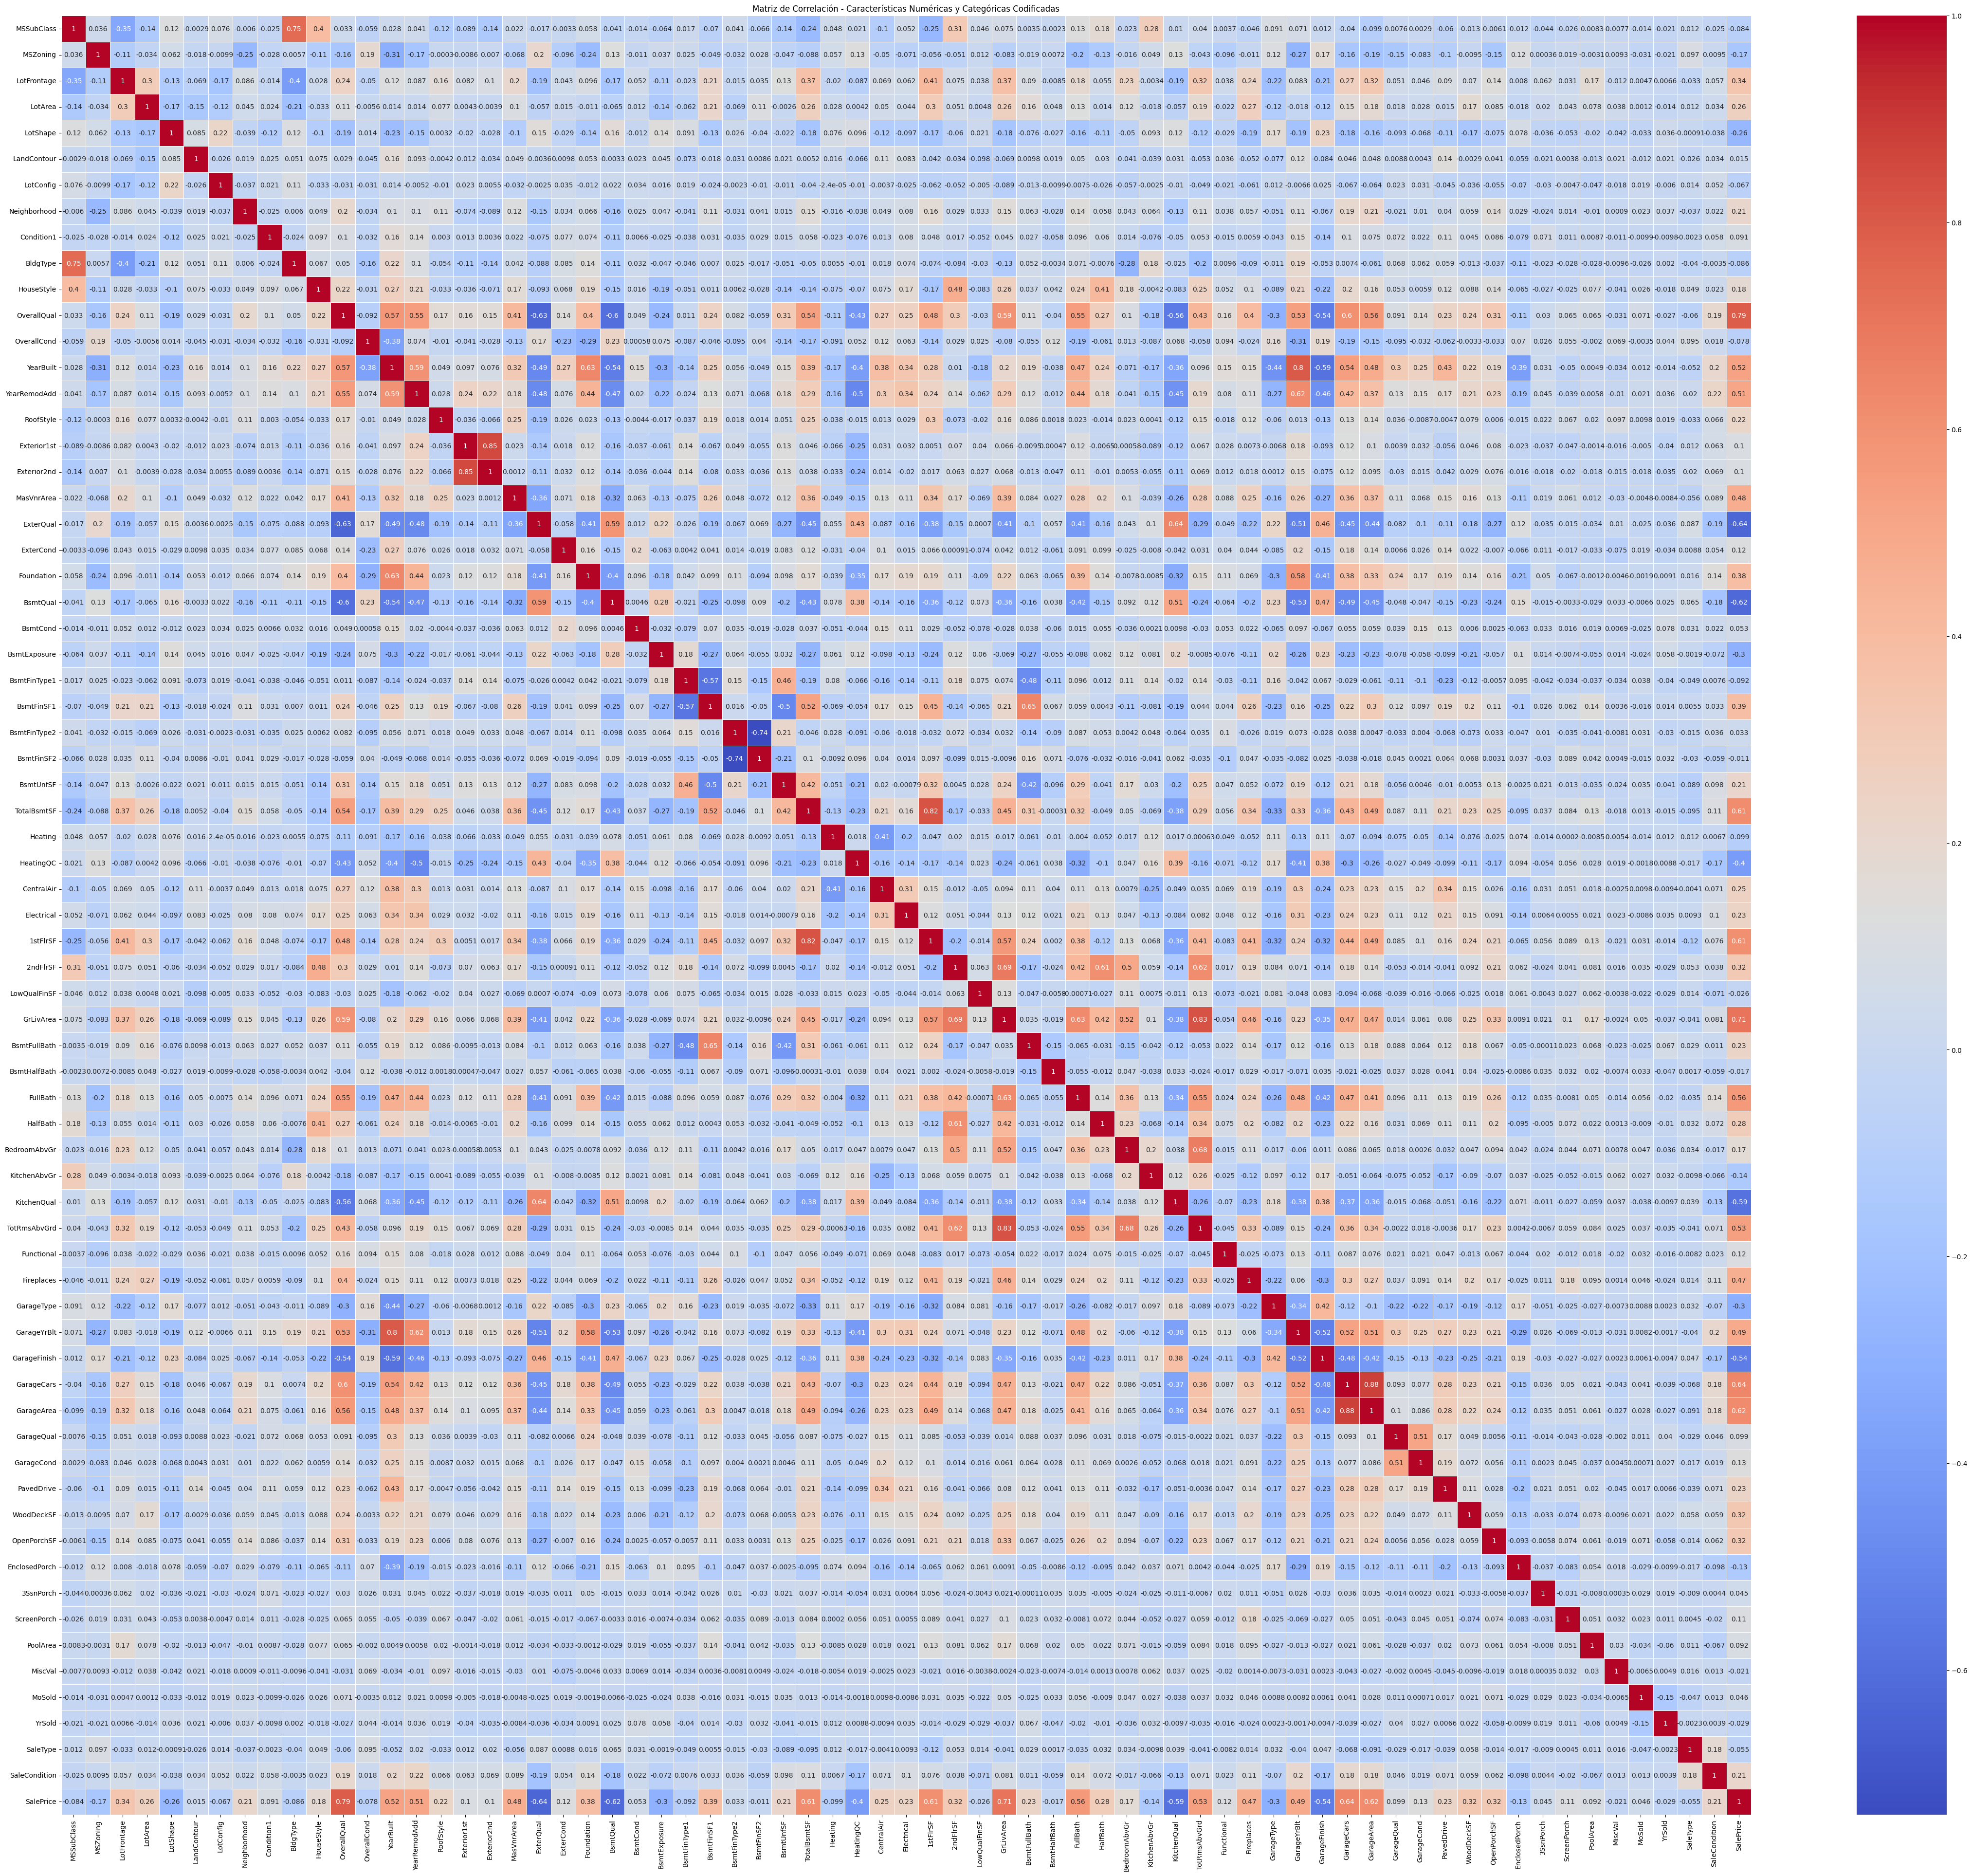

In [10]:
# Copiar el DataFrame original
train_encoded = train_cleaned.copy()
categorical_columns_only = train_encoded.select_dtypes(include=['object', 'string']).columns.tolist()
# Codificar cada columna categórica
label_encoders = {}
for col in categorical_columns_only:
    le = LabelEncoder()
    train_encoded[col] = le.fit_transform(train_cleaned[col].astype(str))
    label_encoders[col] = le

# Filtrar solo las columnas numéricas del DataFrame, incluidas las categóricas codificadas
numerical = train_encoded.select_dtypes(include=['number']).drop(columns=['Id'])

# Calcular la matriz de correlación para las columnas numéricas
correlation_matrix = numerical.corr()

# Crear la matriz de calor (heatmap) usando seaborn
plt.figure(figsize=(56, 48))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Matriz de Correlación - Características Numéricas y Categóricas Codificadas")
plt.show()

In [11]:
# Preparar X e y
y = np.log1p(train['SalePrice'])
X = numerical.drop(columns=['SalePrice'])

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Definir los mejores hiperparámetros para CatBoost
best_params = {
    'learning_rate': 0.03,
    'l2_leaf_reg': 3,
    'iterations': 1000,
    'depth': 4,
    'bagging_temperature': 1,
    'random_state': 42,
    'verbose': 0
}

# Función para entrenar un modelo y mostrar RMSE
def train_and_explain(model, model_name):
    model.fit(X_train, y_train)
    
    # Predicciones
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Evaluación
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    print(f"RMSE en el conjunto de entrenamiento ({model_name}): {train_rmse}")
    print(f"RMSE en el conjunto de prueba ({model_name}): {test_rmse}")
    print(f"-------------------------------------------------------------")

# Entrenar modelos
models = {
    'CatBoost': CatBoostRegressor(**best_params)
}

for name, model in models.items():
    train_and_explain(model, name)

RMSE en el conjunto de entrenamiento (CatBoost): 0.06510159636176734
RMSE en el conjunto de prueba (CatBoost): 0.1312328731066673
-------------------------------------------------------------


In [13]:
# Ensamblar los modelos mediante apilamiento (stacking)
train_stack = np.column_stack([model.predict(X_train) for model in models.values()])
test_stack = np.column_stack([model.predict(X_test) for model in models.values()])

# Entrenar el meta-modelo (Ridge)
meta_model = Ridge()
meta_model.fit(train_stack, y_train)

# Predicciones finales
final_train_pred = meta_model.predict(train_stack)
final_test_pred = meta_model.predict(test_stack)

# Evaluación del modelo final
train_rmse = np.sqrt(mean_squared_error(y_train, final_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, final_test_pred))

print(f"RMSE en el conjunto de entrenamiento (meta-modelo): {train_rmse}")
print(f"RMSE en el conjunto de prueba (meta-modelo): {test_rmse}")

RMSE en el conjunto de entrenamiento (meta-modelo): 0.06483417951023088
RMSE en el conjunto de prueba (meta-modelo): 0.13062249559539726


In [14]:
columns_to_drop_test = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType', 'FireplaceQu', 'Utilities', 'Street', 'LandSlope', 'Condition2','RoofMatl']
test_cleaned = test.drop(columns=columns_to_drop_test)

# Calcular el porcentaje de nulos y tipo de dato para train y test
test_null_info = null_percentage_with_type(test_cleaned)

# Mostrar las tablas con tabulate
print("Null Percentage and Types in Train Data:")
print(tabulate(test_null_info, headers='keys', tablefmt='grid'))
#-------------------------------
# Imputación de valores numéricos usando KNN
knn_columns_test = ['LotFrontage', 'GarageYrBlt', 'MasVnrArea','BsmtHalfBath','GarageCars','GarageArea','TotalBsmtSF','BsmtUnfSF','BsmtFinSF2','BsmtFinSF1',"BsmtFullBath"]
knn_imputer_test = KNNImputer(n_neighbors=7)
test_cleaned[knn_columns_test] = knn_imputer_test.fit_transform(test_cleaned[knn_columns_test])
#-------------------------------

Null Percentage and Types in Train Data:
+--------------+--------------+--------------+-------------------+--------+
|              | Column       |   Null Count |   Percentage Null | Type   |
+==============+==============+==============+===================+========+
| LotFrontage  | LotFrontage  |          227 |        15.5586    | number |
+--------------+--------------+--------------+-------------------+--------+
| GarageCond   | GarageCond   |           78 |         5.34613   | string |
+--------------+--------------+--------------+-------------------+--------+
| GarageQual   | GarageQual   |           78 |         5.34613   | string |
+--------------+--------------+--------------+-------------------+--------+
| GarageYrBlt  | GarageYrBlt  |           78 |         5.34613   | number |
+--------------+--------------+--------------+-------------------+--------+
| GarageFinish | GarageFinish |           78 |         5.34613   | string |
+--------------+--------------+--------------+-

In [15]:
# Calcular el porcentaje de nulos y tipo de dato para train y test
test_null_info = null_percentage_with_type(test_cleaned)

# Mostrar las tablas con tabulate
print("Null Percentage and Types in Train Data:")
print(tabulate(test_null_info, headers='keys', tablefmt='grid'))

Null Percentage and Types in Train Data:
+--------------+--------------+--------------+-------------------+--------+
|              | Column       |   Null Count |   Percentage Null | Type   |
+==============+==============+==============+===================+========+
| GarageFinish | GarageFinish |           78 |         5.34613   | string |
+--------------+--------------+--------------+-------------------+--------+
| GarageQual   | GarageQual   |           78 |         5.34613   | string |
+--------------+--------------+--------------+-------------------+--------+
| GarageCond   | GarageCond   |           78 |         5.34613   | string |
+--------------+--------------+--------------+-------------------+--------+
| GarageType   | GarageType   |           76 |         5.20905   | string |
+--------------+--------------+--------------+-------------------+--------+
| BsmtCond     | BsmtCond     |           45 |         3.0843    | string |
+--------------+--------------+--------------+-

In [16]:
# Identificar las columnas con valores nulos
columns_with_nans_test = ['GarageFinish', 'GarageQual', 'GarageCond', 'GarageType', 
                      'BsmtCond', 'BsmtQual', 'BsmtExposure', 
                      'BsmtFinType1', 'BsmtFinType2', 'MSZoning', 'Functional', 'Exterior1st', 'Exterior2nd', 'KitchenQual', 'SaleType']
# Imputación de valores categóricos usando la moda
for col in columns_with_nans_test:
    # Calcular la moda para la columna
    mode_value = test_cleaned[col].mode()[0]
    # Imputar los valores nulos con la moda
    test_cleaned[col] = test_cleaned[col].fillna(mode_value)

# Calcular el porcentaje de nulos y tipo de dato para train y test
test_null_info = null_percentage_with_type(test_cleaned)

# Mostrar las tablas con tabulate
print("Null Percentage and Types in Train Data:")
print(tabulate(test_null_info, headers='keys', tablefmt='grid'))

Null Percentage and Types in Train Data:
+----------+--------------+-------------------+--------+
| Column   | Null Count   | Percentage Null   | Type   |
+==========+==============+===================+========+
+----------+--------------+-------------------+--------+


In [17]:
categorical_columns_only_test = test_cleaned.select_dtypes(include=['object', 'string']).columns.tolist()
# Codificar cada columna categórica
label_encoders = {}
for col in categorical_columns_only_test:
    le = LabelEncoder()
    test_cleaned[col] = le.fit_transform(test_cleaned[col].astype(str))
    label_encoders[col] = le

# Filtrar solo las columnas numéricas del DataFrame, incluidas las categóricas codificadas
numerical_test = test_cleaned.select_dtypes(include=['number'])

In [18]:
# Filtrar solo las columnas numéricas del DataFrame, incluidas las categóricas codificadas
numerical_test = test_cleaned.select_dtypes(include=['number'])

numerical_test = numerical_test[X_train.columns]  

# Hacer predicciones sobre el conjunto de prueba utilizando todos los modelos
test_stack = np.column_stack([model.predict(numerical_test) for model in models.values()])

# Hacer predicciones con el meta-modelo
predictions = meta_model.predict(test_stack)

# Aplicar la transformación inversa
predictions_exp = np.expm1(predictions)  # Revirtiendo la transformación logarítmica

# Crear el DataFrame para la presentación
submission = pd.DataFrame({
    'Id': test['Id'],  
    'SalePrice': predictions_exp
})

# Guardar en un archivo CSV
submission.to_csv('submission.csv', index=False)

print("Predicciones guardadas en 'submission.csv'.")

Predicciones guardadas en 'submission.csv'.
